# Simulating Queuing Systems

Queuing theory is one of the foundations for the analysis of discrete-event systems. This notebook introduces the nomenclature and terminology of queuing theory that will be used in later applications.

## Examples of Queues

### Manufacturing Lines

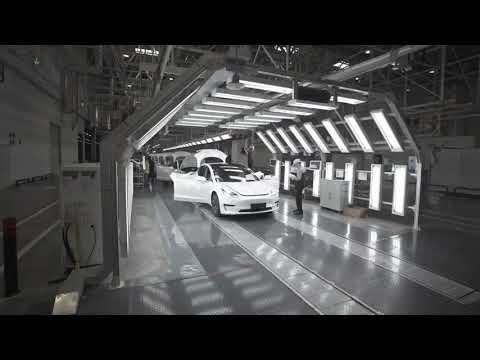

In [109]:
from IPython.display import YouTubeVideo
YouTubeVideo('yUVuiZUhbyA', width=560, height=315)


[Tesla China - Shanghai Gigafactory production line](https://electrek.co/2020/08/31/tesla-video-production-gigafactory-shanghai-alien-dreadnought/?fbclid=IwAR2jHUZMQG4Gl77ugYHvm3DTq-zV5iOuN3bMNePzJswvfY_VVgYP3W7pSZQ).


### Service Lines

![mathworks queue](https://blogs.mathworks.com/images/seth/2015Q1/queues.png)

## Concepts

### Nomenclature


* Servers
* Arrival rate
* Departure rate
* Queuing area or waiting area

### Service Disciplines (of many possibilities)

* First-in-first-out (FIFO or FCFS)
* Last in first out (LIFO)
* Shortest job first
* Priority queue, no interruption
* Priority queue with premption
* Earliest due date

## Poisson Process

Poisson processes describe the occurance of independent random events. Examples:

* Arrival of customers, orders, or other entities from totally independent sources.
* Machine failures when characterized by a mean time between failures (MTBF)
* Physical phenomena like molecules striking a surface, meteor strikes.

Poisson processes are a useful approximation for many simulations, and also very easy to implement in practice. This section introduces some theory before describing a typical implementation.

### Binomial distribution

Suppose there is a probability $p$ of an event occurring in a short interval. We'll assume the interval is short enough that two or more events in the same interval would be extremely unlikely. Assuming each event is independent, the probability of seeing $k$ events in $n$ intervals is given by the binomial distribution

$$\text{Binomial}(k | n, p) = \frac{n!}{k! (n-k)!} p^k (1 - p)^{n-k}$$

The term $p^k (1 - p)^{n-k}$ is the probability of seeing a particular sequence of $k$ intervals with events and $n-k$ intervals with no events, assuming all of the events are independent of one another. The multiplier $\frac{n!}{k! (n-k)!}$ is the number of different sequences that can be constructed from $k$ events occurring in $n$ intervals.

Text(0.5, 1.0, 'Binomial Distribution n=20, p=0.2')

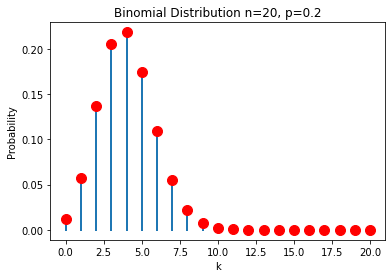

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt

def factorial(n):
    return 1 if n<=1 else n * factorial(n-1)

def combination(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

def binomial(k, n, p):
    return combination(n, k) * p**k * (1-p)**(n-k)

n = 20
p = 0.20

for k in range(0, n+1):
    y = binomial(k, n, p)
    plt.plot([k, k], [0, y], 'C0', lw=2)
    plt.plot(k, y, 'r.', ms=20)
plt.xlabel('k')
plt.ylabel('Probability')
plt.title(f"Binomial Distribution n={n}, p={p}")

### Poisson distribution

Now imagine the events are occuring at an average rate $r$ of events per unit time. In period $t$ there would be, on average, $r t$ events. If that period is broken into $n$ intervals then 

$$ p = \frac{rt}{n}$$

which leads to the Poisson distribution 

$$\begin{align*}
\text{Poisson}(k | r, t) & = 
\lim_{n\rightarrow\infty}\text{Binomial}(k | n, \frac{rt}{n}) \\
& = \lim_{n\rightarrow\infty} \frac{n!}{k! (n-k)!} (\frac{rt}{n})^k (1 - \frac{rt}{n})^{n-k}
\end{align*}$$

We're interested in the limit $n\rightarrow\infty$. Without detailing the math, the limit works out to be

$$\text{Poisson}(k | r, t) = \frac{(rt)^k e^{-rt}}{k!}$$

which is the probability of seeing $k$ events in an interval of length $t$ when the average rate is $r$ events per unit time.

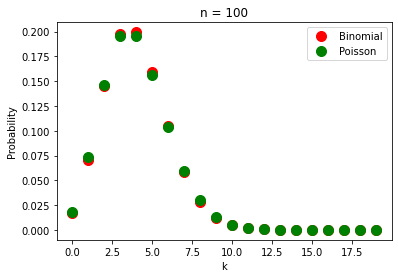

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def factorial(n):
    return 1 if n<=1 else n * factorial(n-1)

def combination(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

def binomial(k, n, p):
    return combination(n, k) * p**k * (1-p)**(n-k)

def poisson(k, r, t):
    return (r*t)**k * np.exp(-r*t)/factorial(k)

t = 2.0
r = 2.0

n = 100
p = r*t/n

k = range(0, 20)
plt.plot(k, [binomial(k, n, p) for k in k], 'r.', ms=20, label="Binomial")
plt.plot(k, [poisson(k, r, t) for k in k], 'g.', ms=20, label="Poisson")
plt.xlabel("k")
plt.ylabel("Probability")
plt.title(f"n = {n}")
plt.legend()


### Waiting time between events

Suppose an event has just occurred. What is the probability of no additional events in the next $t$ units of time? This is calculated with the Poisson distribution where $k=0$.

$$\text{Poisson}(0 | r, t) = e^{-r t}$$

We can treat this as the probability distribution for the time period between events. We refer to this as the exponential distribution

$$\text{Exponential}(t | r) =  e^{-r t}$$

This fact is useful in creating simulations of independent random events. For a given rate $r$, we sample values from an exponential distribution. 

## Simulating a Poisson Process in SimPy

Poisson processes are easy to implement in SimPy. A single parameter, commonly denoted as $r$ or $\lambda$, is required to specify the average rate of occurance in units of number per unit time. For example, a value $\lambda = 4.2 \text{ min}^{-1}$ corresponds to an average of 4.2 events per minute.

An alternative specification is so express the mean time between events. The rate of machine failures, for example, is typically specified as "mean time between failures" (MTBF). In these cases, $r = \lambda = \frac{1}{\bar{\tau}}$ where $\bar{\tau}$ is the mean time between events.

Once the mean rate has been determined, the time between events can be simulated by drawing samples from an exponential distribution

$$\text{Exponential}(t | r) =  e^{-r t}$$

The following cell demonstrates the simulation of a Poisson process with an average $r$ events per unit time.

In [121]:
%matplotlib inline
import simpy
import random
import matplotlib.pyplot as plt

# average rate: events per unit time
r = 2.0 

def arrival(r):
    while True:
        yield env.timeout(random.expovariate(r))
        data_log.append(env.now)

data_log = []  
env = simpy.Environment()
env.process(arrival(r))
env.run(10000)

Visualization

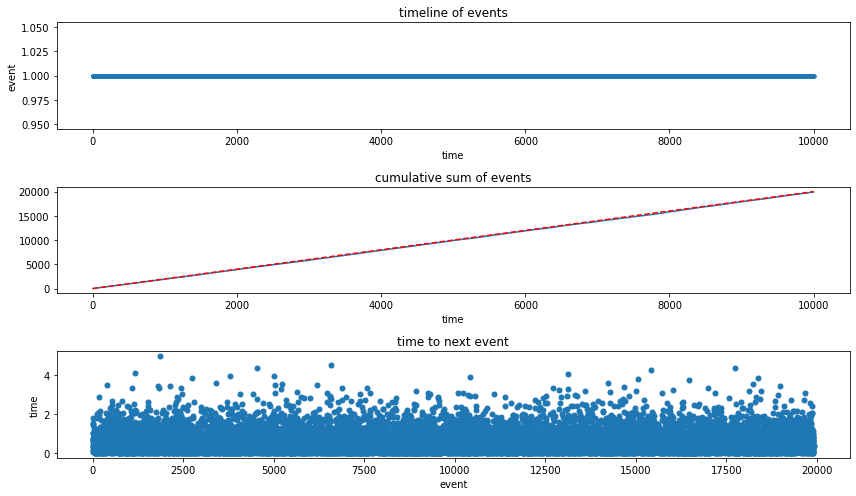

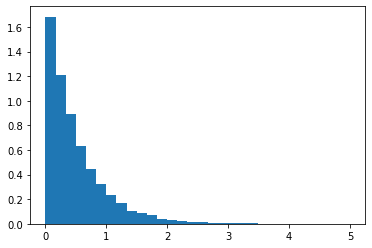

In [122]:
fig, ax = plt.subplots(3, 1, figsize=(12, 7))
ax[0].plot(data_log, np.ones((len(data_log), 1)), '.')
ax[0].set_xlabel('time')
ax[0].set_ylabel('event')
ax[0].set_title('timeline of events')

ax[1].plot(data_log, range(1, len(data_log)+1))
ax[1].plot(data_log, r*np.array(data_log), 'r--')
ax[1].set_xlabel("time")
ax[1].set_title("cumulative sum of events")

ax[2].plot(np.diff(data_log), '.', ms=10)
ax[2].set_xlabel("event")
ax[2].set_ylabel("time")
ax[2].set_title("time to next event")

plt.tight_layout()

fig, ax = plt.subplots(1, 1)
ax.hist(np.diff(data_log), bins=30, density=True);

## Kendall notation for queues

Kendall notation is a standardized methods to describe and classify queues. The notation consists of three factors written as A/S/c where where A describes the arrival process, S the service process, and c is the number of servers attending the queue.

* $A/S/c$
    * $A$: statistical nature of the arrival process 
    * $S$: Statistical nature of the service process 
    * $c$: Number of servers at the queue node
    
* Typical Statistics
    * D: Deterministic (average arrival rate $\lambda$)
    * M: Markov or memoryless (average arrival rate $r$)
    * G: General or arbitrary distribution (mean $\mu$ and standard deviation $\simga$ or variance $\sigma^2$)
    
Example: M/D/1

![Aircraft queue](https://i0.wp.com/nats.aero/blog/wp-content/uploads/2013/08/aircraft-queue-e1377251576844.jpg?ssl=1)

Example: M/M/8

![Call Center](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Emergency_Call_Center_112.jpg/640px-Emergency_Call_Center_112.jpg)

## Example: Simulation of an Order Processing Queue

A chemical storeroom processes orders for a large research campus. At peak loads it is expected to receive an average of one order every 12 minutes. The time required to process each order is a fixed 10 minutes. 

1. Describe the process using the Kendall notation: M/D/1

2. Create a simulation of the order queue that operates for 8 hours. Determine the average time between the arrival and completion of an order, and determine the average queue length. 

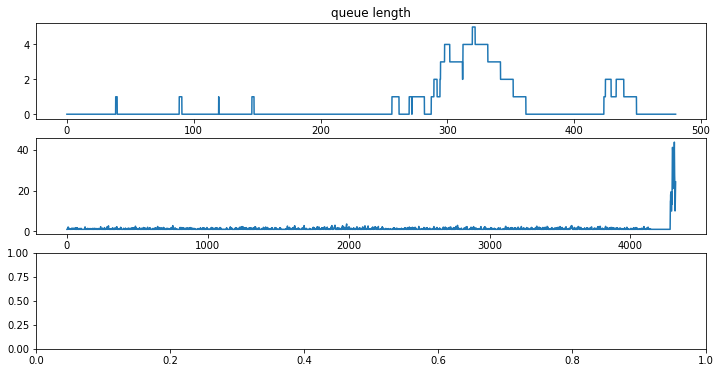

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import pandas as pd

# time unit = minutes

order_log = []    # log data on order processing
queue_log = []    # log data on queue length

# log time and queue_length at regular time steps
def queue_logger(t_step=1.0):
    while True:
        queue_log.append([env.now, len(queue.items)])
        yield env.timeout(t_step)

# generate and place orders on the queue at a specified rate
def order_generator(order_rate):
    order_id = 1
    while True:
        yield env.timeout(random.expovariate(order_rate))
        yield queue.put([order_id, env.now])
        order_id += 1
    
# process orders from the queue with a specified processing time
def server(t_process):
    while True:
        order_id, time_placed = yield queue.get()
        yield env.timeout(t_process)
        log.append([order_id, time_placed, env.now])
        
env = simpy.Environment()
queue = simpy.Store(env)

env.process(queue_logger(0.1))
env.process(order_generator(1/12.0))
env.process(server(10.0))

env.run(until=8*60)

queue_df = pd.DataFrame(queue_log, columns=["time", "queue length"])
order_df = pd.DataFrame(order_log, columns=["order id", "start", "finish"])

fig, ax = plt.subplots(3, 1, figsize=(12, 6))

ax[0].plot(queue_df["time"], queue_df["queue length"])
ax[0].set_xlabel("time / min")
ax[0].set_title("queue length")

order_df["elapsed"] = order_df["finish"] - order_df["start"]
ax[1].plot(df_orders["elapsed"])
#ax[1].hist(df_orders["elapsed"], bins=int(np.sqrt(len(df_orders.index))));
#ax[1].set_xlim((0,ax[1].get_xlim()[1]))